In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn nos ofrece una variedad ampliada de modelos Naive Bayes, para este problema usamos MultinomialNB que es pensado para este tipo de problemas
from sklearn.naive_bayes import MultinomialNB   

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# TP3: Detector de SPAM

Uno de los problemas más comunes en la clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo. La detección de SPAM es un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para eludir los filtros de correo no deseado. Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado una variedad de técnicas más avanzadas en la detección de SPAM, que incluyen algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico, utilizaremos un conjunto de datos que consta de 4601 observaciones de correos electrónicos, de los cuales 2788 son correos legítimos y 1813 son correos SPAM. Dado que el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo de alguna manera. Para este conjunto de datos, ya se ha aplicado un procesamiento típico en el Procesamiento del Lenguaje Natural (NLP), que consiste en contar la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural (NLP) desempeña un papel fundamental en la detección de SPAM, ya que permite analizar el contenido de los correos electrónicos y extraer características relevantes para la clasificación. Además de contar la frecuencia de palabras, se pueden utilizar técnicas más sofisticadas, como la extracción de características semánticas y el análisis de sentimientos, para mejorar la precisión de los modelos de detección de SPAM.

En este proceso, se cuenta la cantidad de ocurrencias de cada palabra en los diferentes correos.

![spam counter](./spam.png)

Con el fin de preservar la privacidad de los mensajes, la frecuencia de palabras se encuentra normalizada. El conjunto de datos está compuesto por 54 columnas de atributos que se denominan:

- `word_freq_XXXX`: Donde `XXXX` es la palabra o símbolo. Los valores son enteros que van de 0 a 20k.

Además, hay una columna adicional llamada `spam`, que es 1 si el correo es SPAM o 0 si no lo es.

Los clasificadores de Bayes ingenuos fueron los primeros filtros utilizados por las aplicaciones de correo electrónico, basados en este principio de palabras. La idea es que, partiendo de un dato a priori sobre la probabilidad de que un correo sea SPAM o no, ciertas palabras nos indicarán que la probabilidad a posteriori, dadas esas palabras, es más probable que el correo sea SPAM o no.

In [26]:
dataset = pd.read_csv("spambase.csv") # cargando los datos desde un CSV
dataset.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1
6,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.00,0.054,0.0,0.164,0.054,0.000,1.671,4,112,1
7,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.00,0.206,0.0,0.000,0.000,0.000,2.450,11,49,1
8,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,...,0.00,0.271,0.0,0.181,0.203,0.022,9.744,445,1257,1
9,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,...,0.04,0.030,0.0,0.244,0.081,0.000,1.729,43,749,1


Para obtener las palábras más usadas podemos hacer un `groupby`:

In [27]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()

Y despues se pueden combinar las columnas en usando [pd.melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)

In [28]:
# Obtenemos los atributos y target
X = (dataset.drop(columns="spam") * 100).astype(int)
#X = dataset2.drop(columns="spam")
y = dataset["spam"]

Se separa el dataset en entrenamiento y evaluación

In [29]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3)

Escalamos para aplicar en regresión logística

In [30]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformamos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

## Ejercicio 1

In [31]:
spam_word_frecuencies = column_sum.loc[1].sort_values(ascending=False)
no_spam_word_frecuencies = column_sum.loc[0].sort_values(ascending=False)
print('Spam:\n', spam_word_frecuencies.head(10))
print('No Spam:\n', no_spam_word_frecuencies.head(10))

common_words = set(spam_word_frecuencies.head(10).index).intersection(set(no_spam_word_frecuencies.head(10).index))
print("\nPalabras en común en SPAM y No SPAM:")
print(common_words)

Spam:
 capital_run_length_total      853233.000
capital_run_length_longest    189265.000
capital_run_length_average     17258.246
word_freq_you                   4105.610
word_freq_your                  2502.610
word_freq_will                   997.100
word_freq_free                   939.790
word_freq_our                    931.800
char_freq_!                      931.361
word_freq_all                    732.080
Name: 1, dtype: float64
No Spam:
 capital_run_length_total      450181.000
capital_run_length_longest     50782.000
capital_run_length_average      6627.915
word_freq_you                   3541.710
word_freq_george                3527.560
word_freq_hp                    2496.580
word_freq_will                  1495.270
word_freq_your                  1223.100
word_freq_hpl                   1204.400
word_freq_re                    1159.140
Name: 0, dtype: float64

Palabras en común en SPAM y No SPAM:
{'capital_run_length_average', 'capital_run_length_total', 'word_freq_your', 

## Ejercicio 2

In [32]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=50)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformamos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

## Ejercicio 3

In [33]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred_naive_bayes_classifier = naive_bayes_classifier.predict(X_test)


## Ejercicio 4

In [34]:
logistic_regresion_classifier = LogisticRegression()
logistic_regresion_classifier.fit(X_train_scaled, y_train)
y_pred_logistic_regresion_classifier = logistic_regresion_classifier.predict(X_test_scaled)

## Ejercicio 5

In [35]:
# Evaluar el rendimiento
conf_matrix_naive_bayes_classifier = confusion_matrix(y_test, y_pred_naive_bayes_classifier)
conf_matrix_logistic_regresion_classifier = confusion_matrix(y_test, y_pred_logistic_regresion_classifier)


print("\nMatriz de confusión Bayes Ingenuo:")
print(conf_matrix_naive_bayes_classifier)
print("\nMatriz de confusión Regresion Logistica:")
print(conf_matrix_logistic_regresion_classifier)


Matriz de confusión Bayes Ingenuo:
[[727 125]
 [134 395]]

Matriz de confusión Regresion Logistica:
[[811  41]
 [101 428]]


## Ejercicio 6

In [36]:
# Precisión y recuperación para Bayes ingenuo
accuracy_naive_bayes_classifier = precision_score(y_test, y_pred_naive_bayes_classifier)
recall_nb = recall_score(y_test, y_pred_naive_bayes_classifier)

# Precisión y recuperación para Regresión Logística
accuracy_logistic_regresion_classifier = precision_score(y_test, y_pred_logistic_regresion_classifier)
recall_lr = recall_score(y_test, y_pred_logistic_regresion_classifier)


print("Exactitud del clasificador de Bayes ingenuo:", accuracy_naive_bayes_classifier, ", Recuperacion:", recall_nb)
print("Exactitud del clasificador de Regresion Logistica:", accuracy_logistic_regresion_classifier, ", Recuperacion:", recall_lr)

Exactitud del clasificador de Bayes ingenuo: 0.7596153846153846 , Recuperacion: 0.7466918714555766
Exactitud del clasificador de Regresion Logistica: 0.9125799573560768 , Recuperacion: 0.8090737240075614


## Ejercicio 7

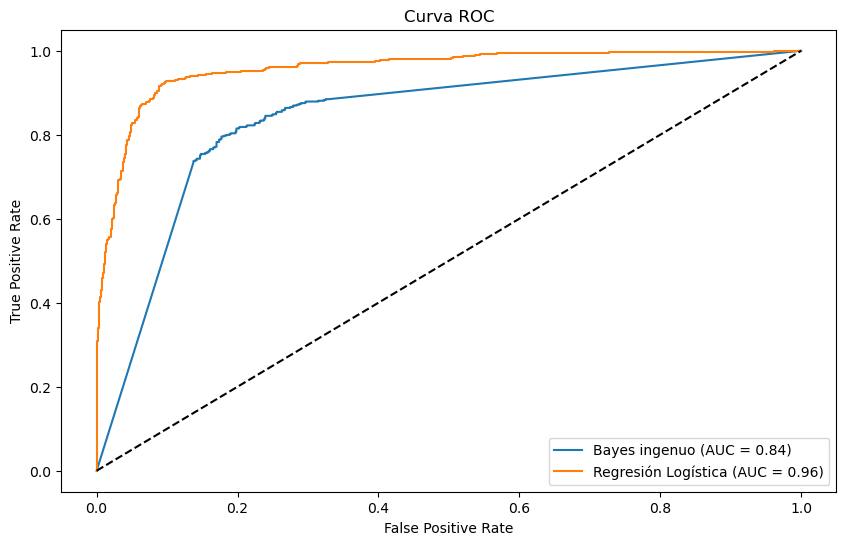

In [37]:
# ROC y AUC para Bayes ingenuo
y_prob_nb = naive_bayes_classifier.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
auc_nb = roc_auc_score(y_test, y_prob_nb)

# ROC y AUC para Regresión Logística
y_prob_lr = logistic_regresion_classifier.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, label=f'Bayes ingenuo (AUC = {auc_nb:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Regresión Logística (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()